# <center>Assignment 2 LSTM - Fixed Window Size Loop with Seasonal Difference
   

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [4]:
# RNN Package Setting
import time
import math
import statsmodels.api as smapi
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

np.random.seed(1)

Using Theano backend.


## Data Preparation

In [5]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values
len(sales)

137

### First Order ACF & PACF Plot

In [6]:
sales_diff=pd.Series.diff(data)
sales_diff=sales_diff.dropna().values
# sales_diff

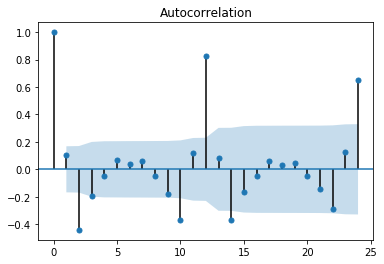

In [7]:
fig=smt.graphics.plot_acf(sales_diff, lags=24)
plt.show()
fig.savefig('ACF.png',dpi=1000)

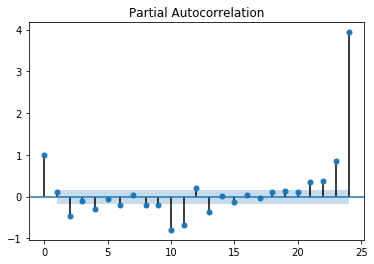

In [8]:
fig=smt.graphics.plot_pacf(sales_diff, lags=24)
plt.show()
fig.savefig('PACF.png',dpi=1000)

### Seasonal Difference

In [10]:
# First Order Difference
# sales_diff=pd.Series.diff(data)
# sales_diff=sales_diff.dropna().values

# Seasonally First Order Difference
season_diff=pd.Series.diff(data,periods=12)

season_diff=season_diff.dropna().values

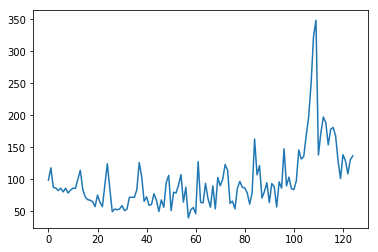

In [11]:
plt.figure()
plt.plot(season_diff)
plt.show()

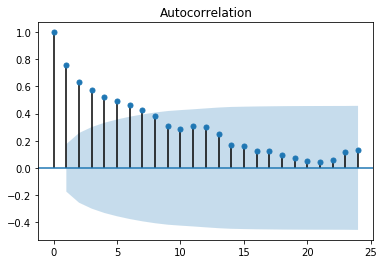

In [12]:
fig=smt.graphics.plot_acf(season_diff, lags=24)
plt.show()
fig.savefig('SACF.png',dpi=1000)

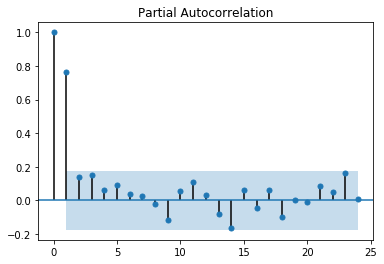

In [13]:
fig=smt.graphics.plot_pacf(season_diff, lags=24)
plt.show()
fig.savefig('SPACF.png',dpi=1000)

### Standardisation - Trend Standardisation

In [14]:
# Standardisation
scaler = StandardScaler()
diff_scaled=scaler.fit_transform(season_diff)

# Std & Mean Calculation
diff_std=np.std(season_diff)
diff_mean=np.mean(season_diff)

print(diff_std)
print(diff_mean)

48.15649823814019
97.70880000000001


## RNN- Model Training

### Trend Model Fitting

In [21]:
# Model Fitting
epochs=200
repeats=5

neurons_min=1
neurons_max=2

window_min=2
window_max=3

step=1

# train_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# cv_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# test_loss=[np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))]
train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss=[]

for w in range(window_min,window_max):
       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(diff_scaled)):
        Xall.append(diff_scaled[i-time_window:i,0])
        yall.append(diff_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    
    # Unscaled Data Preparation for Evaluation
    y_train_raw=season_diff[0:-test_size]
    y_test_raw=season_diff[-test_size:]   

    # Validation Train Test Split
    Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
    ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]
    # Unscaled Data Preparation for Evaluation
    # Trend
    y_train_pse_raw=y_train_raw[0:-test_size]
    y_test_pse_raw=y_train_raw[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
    Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)


    for n in range(neurons_min,neurons_max,step):
    #         fig=plt.figure()  
        rmse_t=[]
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain_pse,ytrain_pse, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Test RMSE - For my own happiness
            test_predict_pse = model.predict(Xtest_pse,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict_pse)  
            
            # Trend RMSE
            rmse_t.append(math.sqrt(mean_squared_error(y_test_pse_raw,test_predict_pse)))
                
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*diff_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*diff_std)
        
        # TREND            
        rmse_t.append(np.mean(rmse_t)) # calculate mean and std of Trend RMSE
        rmse_t.append(np.std(rmse_t))
        test_loss.append(rmse_t) # append mean and std of rmse

# plt.plot(train_loss,color='blue')
# plt.plot(cv_loss,color='orange')
    
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # # plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# fig.savefig('epochs_tuning.png',dpi=1000)

Compilation Time :  0.007980108261108398
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.3434 - val_loss: 0.2009
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.3032 - val_loss: 0.2007
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2754 - val_loss: 0.2046
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2539 - val_loss: 0.2117
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2393 - val_loss: 0.2206
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2287 - val_loss: 0.2302
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2219 - val_loss: 0.2394
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2177 - val_loss: 0.2480
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2106 - val_loss: 0.2560
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2163 - val_loss: 0.2620
Train on 89 samples

Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1986 - val_loss: 0.2609
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1985 - val_loss: 0.2612
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2054 - val_loss: 0.2607
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1985 - val_loss: 0.2603
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1933 - val_loss: 0.2592
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1989 - val_loss: 0.2602
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2030 - val_loss: 0.2606
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2075 - val_loss: 0.2606
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1985 - val_loss: 0.2604
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2039 - val_loss: 0.2601
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.1951 - val_loss: 0.2694
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1892 - val_loss: 0.2697
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2009 - val_loss: 0.2696
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1956 - val_loss: 0.2675
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2068 - val_loss: 0.2678
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2104 - val_loss: 0.2675
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1984 - val_loss: 0.2678
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2048 - val_loss: 0.2667
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1978 - val_loss: 0.2668
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1947 - val_loss: 0.2685
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1997 - val_loss: 0.2696
Train on 89 samples,

 - 0s - loss: 0.1978 - val_loss: 0.2631
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2095 - val_loss: 0.2627
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2042 - val_loss: 0.2627
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2112 - val_loss: 0.2607
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2044 - val_loss: 0.2600
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1951 - val_loss: 0.2594
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2085 - val_loss: 0.2599
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1912 - val_loss: 0.2606
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1979 - val_loss: 0.2629
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2116 - val_loss: 0.2602
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2032 - val_loss: 0.2598
Train on 89 samples,

Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1918 - val_loss: 0.2786
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2054 - val_loss: 0.2770
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2000 - val_loss: 0.2747
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1940 - val_loss: 0.2792
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1942 - val_loss: 0.2788
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2002 - val_loss: 0.2820
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1927 - val_loss: 0.2851
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1979 - val_loss: 0.2844
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1886 - val_loss: 0.2837
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1897 - val_loss: 0.2839
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2054 - val_loss: 0.2559
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2133 - val_loss: 0.2532
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2150 - val_loss: 0.2509
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2074 - val_loss: 0.2522
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2163 - val_loss: 0.2523
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2141 - val_loss: 0.2509
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2132 - val_loss: 0.2500
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2003 - val_loss: 0.2515
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2002 - val_loss: 0.2542
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1988 - val_loss: 0.2557
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.2031 - val_loss: 0.2535
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1907 - val_loss: 0.2558
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1885 - val_loss: 0.2574
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2150 - val_loss: 0.2551
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1894 - val_loss: 0.2572
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2057 - val_loss: 0.2556
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1918 - val_loss: 0.2571
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2033 - val_loss: 0.2572
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2225 - val_loss: 0.2560
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2069 - val_loss: 0.2546
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2038 - val_loss: 0.2548
Train on 89 samples,

 - 0s - loss: 0.2035 - val_loss: 0.2878
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2053 - val_loss: 0.2886
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2170 - val_loss: 0.2846
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2177 - val_loss: 0.2821
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2247 - val_loss: 0.2774
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2109 - val_loss: 0.2815
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2092 - val_loss: 0.2801
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2067 - val_loss: 0.2777
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2174 - val_loss: 0.2747
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2159 - val_loss: 0.2733
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2152 - val_loss: 0.2739
Train on 89 samples,

Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2146 - val_loss: 0.2570
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2180 - val_loss: 0.2555
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2119 - val_loss: 0.2539
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2009 - val_loss: 0.2543
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2027 - val_loss: 0.2549
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2006 - val_loss: 0.2563
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1896 - val_loss: 0.2574
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2165 - val_loss: 0.2539
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2012 - val_loss: 0.2565
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2048 - val_loss: 0.2562
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.1925 - val_loss: 0.2664
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1983 - val_loss: 0.2633
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2054 - val_loss: 0.2628
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1901 - val_loss: 0.2631
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2000 - val_loss: 0.2635
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2018 - val_loss: 0.2638
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1904 - val_loss: 0.2627
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2082 - val_loss: 0.2609
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1929 - val_loss: 0.2616
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2072 - val_loss: 0.2618
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1933 - val_loss: 0.2609
Train on 89 samples,

 - 0s - loss: 0.2032 - val_loss: 0.2627
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2005 - val_loss: 0.2633
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2032 - val_loss: 0.2627
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1956 - val_loss: 0.2623
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2040 - val_loss: 0.2613
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1990 - val_loss: 0.2634
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1898 - val_loss: 0.2654
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2063 - val_loss: 0.2647
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1975 - val_loss: 0.2682
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1968 - val_loss: 0.2705
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1878 - val_loss: 0.2697
Train on 89 samples,

Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2063 - val_loss: 0.2765
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2022 - val_loss: 0.2761
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2016 - val_loss: 0.2751
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2084 - val_loss: 0.2746
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2048 - val_loss: 0.2770
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1917 - val_loss: 0.2766
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1971 - val_loss: 0.2745
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.2052 - val_loss: 0.2740
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1958 - val_loss: 0.2748
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.1990 - val_loss: 0.2754
Train on 89 samples, validate on 10 samples
Epoch 1/1
 - 0s 

In [22]:
test_loss

[[130.18516651806615,
  123.56871858746447,
  131.91831461953478,
  130.78336310258615,
  129.32996070230533,
  129.15710470599137,
  2.6641398315966116]]

In [23]:
# test_loss_sum=[]
# test_loss_multi_sum=[]

test_loss_sum.append(np.array(test_loss))
# test_loss_multi_sum.append(np.array(test_loss_multi))

In [24]:
print(test_loss_sum)

[array([[131.03093188, 130.4190586 , 131.72255342, 130.64284331,
        130.65723602, 130.89452465,   0.41832123]]), array([[130.18516652, 123.56871859, 131.91831462, 130.7833631 ,
        129.3299607 , 129.15710471,   2.66413983]])]


In [25]:
# cv_loss

In [26]:
# cv_loss_res

In [27]:
# train_loss_res

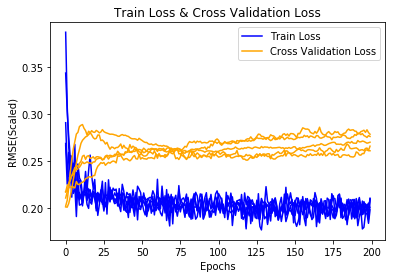

In [28]:
# Cross Validation Visualization
fig=plt.figure()
line1=plt.plot(np.array(train_loss)[0,:],color='blue',label="Train Loss")
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')
# plt.plot(np.array(train_loss)[5,:],color='blue')
# plt.plot(np.array(train_loss)[6,:],color='blue')
# plt.plot(np.array(train_loss)[7,:],color='blue')
# plt.plot(np.array(train_loss)[8,:],color='blue')
# plt.plot(np.array(train_loss)[9,:],color='blue')

line2=plt.plot(np.array(cv_loss)[0,:],color='orange',label= "Cross Validation Loss")
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')
# plt.plot(np.array(cv_loss)[5,:],color='orange')
# plt.plot(np.array(cv_loss)[6,:],color='orange')
# plt.plot(np.array(cv_loss)[7,:],color='orange')
# plt.plot(np.array(cv_loss)[8,:],color='orange')
# plt.plot(np.array(cv_loss)[9,:],color='orange')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE(Scaled)')
plt.title('Train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

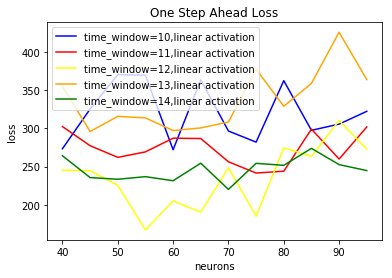

In [268]:
fig=plt.figure()
plt.plot(np.arange(40,100,5),test_loss.iloc[0,:],label='time_window=10,linear activation',color='blue')
plt.plot(np.arange(40,100,5),test_loss.iloc[1,:],label='time_window=11,linear activation',color='red')
plt.plot(np.arange(40,100,5),test_loss.iloc[2,:],label='time_window=12,linear activation',color='yellow')
plt.plot(np.arange(40,100,5),test_loss.iloc[3,:],label='time_window=13,linear activation',color='orange')
plt.plot(np.arange(40,100,5),test_loss.iloc[4,:],label='time_window=14,linear activation',color='green')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('loss')
plt.title('One Step Ahead Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

In [269]:
test_loss.to_excel('Loss_T10-14_N40-100.xlsx')

In [200]:
# Predict
train_predict = model.predict(Xtrain,batch_size=1)
test_predict = model.predict(Xtest,batch_size=1)

# Inverse Prediction
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Training Score

In [201]:
# epochs_summary=[]
# neurons_summary=[]
# rmse_summary=[]
# mae_summary=[]

In [202]:
rmse=math.sqrt(mean_squared_error(y_test_raw,test_predict))
mae=mean_absolute_error(y_test_raw,test_predict)

In [203]:
epochs_summary.append(epochs)
neurons_summary.append(neurons)
rmse_summary.append(rmse)
mae_summary.append(mae)

print(epochs_summary)
print(neurons_summary)
print(rmse_summary)
print(mae_summary)

[300, 300, 300, 300, 300, 300, 300]
[5, 10, 50, 100, 150, 125, 113]
[318.7349936417306, 230.30975251899886, 208.24286191876573, 134.40613515925975, 299.2879239417023, 338.1812868338608, 225.34691825042538]
[260.30489908854173, 126.15896402994788, 146.3288401285807, 111.27141418457029, 243.473257446289, 287.5988016764323, 174.387559000651]


## Diagnostic Plot

ZeroDivisionError: integer division or modulo by zero

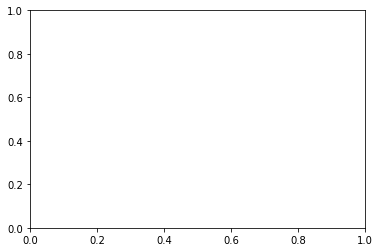

In [101]:
fig=plt.figure()
plt.plot(train_loss_summary)
plt.plot(cv_loss_summary)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
fig.savefig('epochs_tuning.png',dpi=1000)

In [102]:
train_loss_summary

""


## Final Model Fitting

In [ ]:
# Model Fitting
epochs=500
repeats=5

neurons_min=1
neurons_max=2

window_min=2
window_max=3

step=1

# train_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# cv_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# test_loss=[np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))]
train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss=[]

for w in range(window_min,window_max):
       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(diff_scaled)):
        Xall.append(diff_scaled[i-time_window:i,0])
        yall.append(diff_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    
    # Unscaled Data Preparation for Evaluation
    y_train_raw=season_diff[0:-test_size]
    y_test_raw=season_diff[-test_size:]   

#     # Validation Train Test Split
#     Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
#     ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]
#     # Unscaled Data Preparation for Evaluation
#     # Trend
#     y_train_pse_raw=y_train_raw[0:-test_size]
#     y_test_pse_raw=y_train_raw[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
#     Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)


    for n in range(neurons_min,neurons_max,step):
    #         fig=plt.figure()  
        rmse_t=[]
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain,ytrain, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Test RMSE
            # One Step-ahead Forecast
            test_predict = model.predict(Xtest,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict)  
            
            # Trend RMSE
            rmse_t.append(math.sqrt(mean_squared_error(y_test_raw,test_predict)))
                
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*diff_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*diff_std)
        
        # TREND            
        rmse_t.append(np.mean(rmse_t)) # calculate mean and std of Trend RMSE
        rmse_t.append(np.std(rmse_t))
        test_loss.append(rmse_t) # append mean and std of rmse

# plt.plot(train_loss,color='blue')
# plt.plot(cv_loss,color='orange')
    
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # # plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# fig.savefig('epochs_tuning.png',dpi=1000)

Compilation Time :  0.003989458084106445
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6104 - val_loss: 0.9870
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6097 - val_loss: 0.9848
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6076 - val_loss: 0.9814
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6069 - val_loss: 0.9788
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6066 - val_loss: 0.9759
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6036 - val_loss: 0.9734
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5990 - val_loss: 0.9690
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5980 - val_loss: 0.9653
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5973 - val_loss: 0.9616
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5910 - val_loss: 0.9574
Train on 88 samples

Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5166 - val_loss: 0.7917
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4802 - val_loss: 0.7914
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5420 - val_loss: 0.7921
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5250 - val_loss: 0.7926
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4879 - val_loss: 0.7923
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4892 - val_loss: 0.7944
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5285 - val_loss: 0.7944
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4580 - val_loss: 0.7945
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4775 - val_loss: 0.7927
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5408 - val_loss: 0.7927
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4478 - val_loss: 0.7995
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5274 - val_loss: 0.8007
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5240 - val_loss: 0.8034
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4581 - val_loss: 0.8005
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4624 - val_loss: 0.8011
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4798 - val_loss: 0.7996
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4744 - val_loss: 0.8008
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4539 - val_loss: 0.8007
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4556 - val_loss: 0.7983
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5013 - val_loss: 0.7980
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4675 - val_loss: 0.7990
Train on 88 samples,

Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4673 - val_loss: 0.8150
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5006 - val_loss: 0.8147
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5342 - val_loss: 0.8115
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4631 - val_loss: 0.8124
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4926 - val_loss: 0.8119
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4578 - val_loss: 0.8111
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5255 - val_loss: 0.8112
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4846 - val_loss: 0.8133
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4850 - val_loss: 0.8153
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5013 - val_loss: 0.8153
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4526 - val_loss: 0.8295
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4766 - val_loss: 0.8269
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4814 - val_loss: 0.8264
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4910 - val_loss: 0.8283
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4715 - val_loss: 0.8326
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5253 - val_loss: 0.8316
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4680 - val_loss: 0.8310
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4776 - val_loss: 0.8289
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4564 - val_loss: 0.8287
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4671 - val_loss: 0.8282
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4523 - val_loss: 0.8276
Train on 88 samples,

Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4880 - val_loss: 0.8494
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4821 - val_loss: 0.8495
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4622 - val_loss: 0.8506
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4967 - val_loss: 0.8488
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4424 - val_loss: 0.8484
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4463 - val_loss: 0.8484
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4715 - val_loss: 0.8490
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4497 - val_loss: 0.8480
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4951 - val_loss: 0.8473
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5007 - val_loss: 0.8475
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6138 - val_loss: 0.9910
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6128 - val_loss: 0.9902
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6140 - val_loss: 0.9902
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6141 - val_loss: 0.9903
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6138 - val_loss: 0.9902
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6129 - val_loss: 0.9894
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6119 - val_loss: 0.9883
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6131 - val_loss: 0.9878
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6127 - val_loss: 0.9872
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6120 - val_loss: 0.9864
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5510 - val_loss: 0.9204
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5404 - val_loss: 0.9176
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5510 - val_loss: 0.9180
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5554 - val_loss: 0.9190
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5582 - val_loss: 0.9234
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5561 - val_loss: 0.9219
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5444 - val_loss: 0.9213
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5714 - val_loss: 0.9198
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5740 - val_loss: 0.9211
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5477 - val_loss: 0.9214
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5316 - val_loss: 0.9204
Train on 88 samples,

Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5630 - val_loss: 0.9065
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5453 - val_loss: 0.9060
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5615 - val_loss: 0.9054
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5503 - val_loss: 0.9051
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5621 - val_loss: 0.9031
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5765 - val_loss: 0.9046
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5542 - val_loss: 0.9010
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5722 - val_loss: 0.9075
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5347 - val_loss: 0.9031
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5310 - val_loss: 0.8998
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5243 - val_loss: 0.8668
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5315 - val_loss: 0.8678
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5274 - val_loss: 0.8636
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5655 - val_loss: 0.8668
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5366 - val_loss: 0.8663
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5625 - val_loss: 0.8696
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5435 - val_loss: 0.8693
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5219 - val_loss: 0.8639
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5373 - val_loss: 0.8654
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4964 - val_loss: 0.8615
Train on 88 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5123 - val_loss: 0.8603
Train on 88 samples,